=== Thompson Sampling vs Truncation Selection Experiment ===
Population size: 2000
Effective population size: 50
Genome: 10 chromosomes × 100 loci
Total loci: 1,000

1. Creating founder population...


/home/glect/.local/lib/python3.10/site-packages/jax/_src/numpy/array.py:244: RuntimeWarning: invalid value encountered in cast
  out = np.asarray(object, dtype=dtype)


✓ Created founder population: Population(nInd=2000, nTraits=0, has_ebv=No)
✓ Genetic map shape: (10, 100)

2. Initializing simulation parameters...
✓ SimParam created: SimParam(nChr=10, nTraits=1, ploidy=2, sexes='no')

3. Setting initial phenotypes...
✓ Phenotypes set. Population shape: (2000, 1)
✓ Phenotype mean: 0.009
✓ Phenotype std: 1.421

4. Running burn-in for 100 generations...
  Burn-in generation 20/100
  Burn-in generation 40/100
  Burn-in generation 60/100
  Burn-in generation 80/100
  Burn-in generation 100/100
✓ Burn-in completed. Final population: Population(nInd=2000, nTraits=1, has_ebv=No)

5. Running selection experiment...

Running experiment with h² = 0.5, selection intensity = 0.10...

  Running Truncation Selection...
    Generation 2: Mean BV = 2.168
    Generation 4: Mean BV = 4.373
    Generation 6: Mean BV = 5.557
    Generation 8: Mean BV = 5.979
    Generation 10: Mean BV = 6.087
    Generation 12: Mean BV = 6.126
    Generation 14: Mean BV = 6.129
    Gener

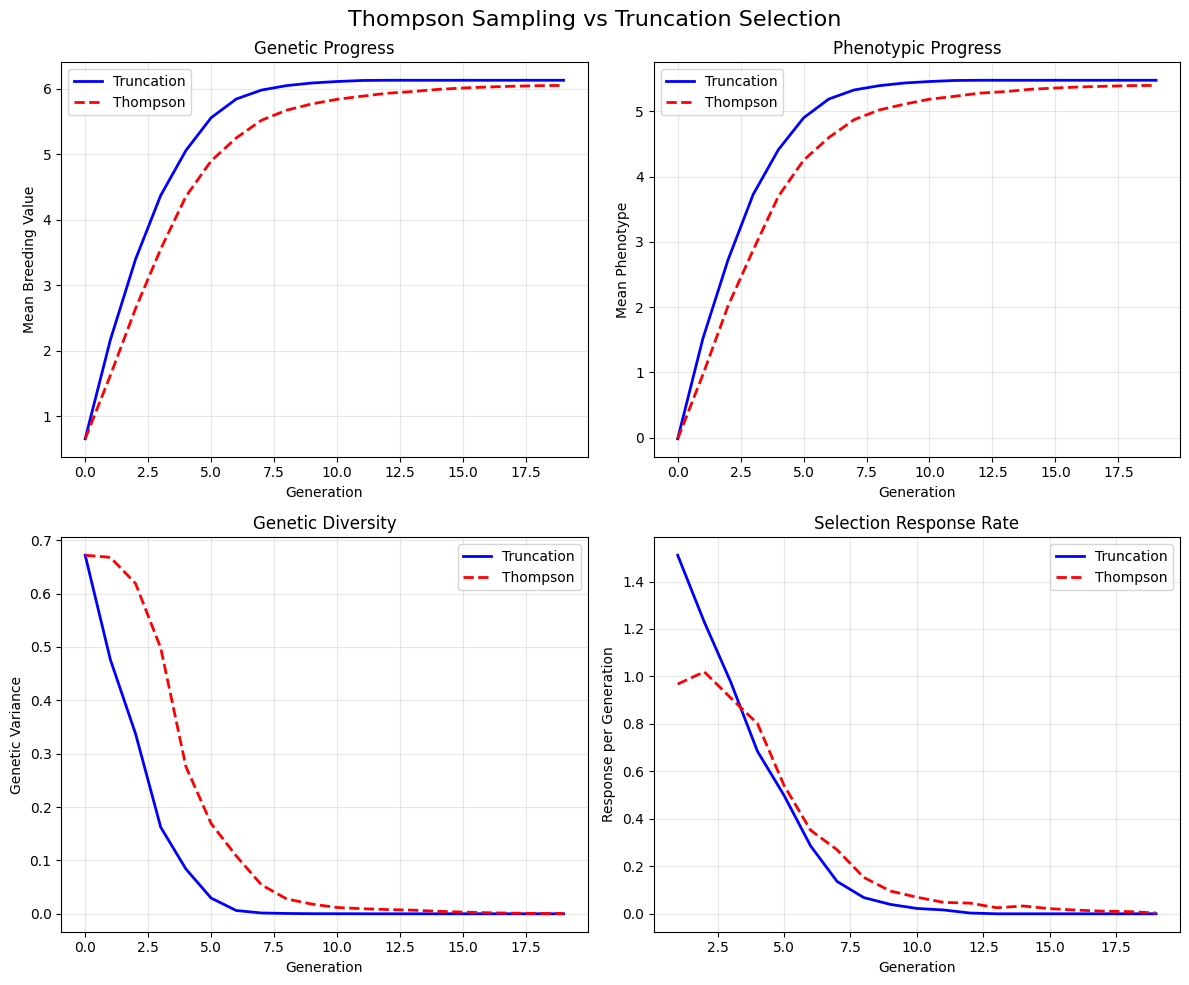


7. Summary Statistics:
Final Mean Breeding Value:
  Truncation: 6.129
  Thompson:   6.050

Total Genetic Response:
  Truncation: 5.472
  Thompson:   5.393

Final Genetic Variance:
  Truncation: 0.000
  Thompson:   0.001

Genetic Variance Retained:
  Truncation: 0.0%
  Thompson:   0.1%

Selection Efficiency (Truncation/Thompson): 1.015
→ Methods performed similarly

Experiment completed successfully!
This demonstrates the trade-off between selection intensity
and genetic diversity maintenance in breeding programs.


In [1]:
# Thompson Sampling vs Truncation Selection Experiment
# Complete experimental pipeline using the chewc library

import jax
import jax.numpy as jnp
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, NamedTuple

# Import chewc modules
from chewc.population import quick_haplo, Population, msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.predict import gblup_predict

# Set random seed for reproducibility
key = jax.random.PRNGKey(42)

# Experimental parameters
EXPERIMENTAL_CONFIG = {
    'population_size': 2000,
    'n_chromosomes': 10,
    'n_loci_per_chr': 100,
    'effective_population_size': 50,
    'heritabilities': [0.1, 0.3, 0.5, 0.7],
    'selection_intensities': [0.01, 0.02, 0.05, 0.10, 0.20],
    'trait_architectures': {
        'oligogenic': {'n_qtl_per_chr': 10, 'gamma_effects': True},
        'polygenic': {'n_qtl_per_chr': 100, 'gamma_effects': False},
        'mixed': {'n_qtl_per_chr': 50, 'gamma_effects': True}
    },
    'n_generations': 20,
    'n_replicates': 5,
    'burn_in_generations': 100
}

print("=== Thompson Sampling vs Truncation Selection Experiment ===")
print(f"Population size: {EXPERIMENTAL_CONFIG['population_size']}")
print(f"Effective population size: {EXPERIMENTAL_CONFIG['effective_population_size']}")
print(f"Genome: {EXPERIMENTAL_CONFIG['n_chromosomes']} chromosomes × {EXPERIMENTAL_CONFIG['n_loci_per_chr']} loci")
print(f"Total loci: {EXPERIMENTAL_CONFIG['n_chromosomes'] * EXPERIMENTAL_CONFIG['n_loci_per_chr']:,}")

# ===== STEP 1: Create Founder Population =====
print("\n1. Creating founder population...")
key, pop_key = jax.random.split(key)

founder_pop, genetic_map = msprime_pop(
    key=pop_key,
    n_ind=EXPERIMENTAL_CONFIG['population_size'],
    n_chr=EXPERIMENTAL_CONFIG['n_chromosomes'],
    n_loci_per_chr=EXPERIMENTAL_CONFIG['n_loci_per_chr'],
    ploidy=2,
    effective_population_size=EXPERIMENTAL_CONFIG['effective_population_size'],
    mutation_rate=2e-8,
    recombination_rate_per_chr=1e-8,
    maf_threshold=0.05
)

print(f"✓ Created founder population: {founder_pop}")
print(f"✓ Genetic map shape: {genetic_map.shape}")

# ===== STEP 2: Initialize Simulation Parameters =====
print("\n2. Initializing simulation parameters...")
sp = SimParam.from_founder_pop(founder_pop, genetic_map)

# Add a quantitative trait for selection
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=sp,
    n_qtl_per_chr=EXPERIMENTAL_CONFIG['trait_architectures']['mixed']['n_qtl_per_chr'],
    mean=jnp.array([0.0]),  # Single trait with mean 0
    var=jnp.array([1.0]),   # Genetic variance of 1
    gamma=EXPERIMENTAL_CONFIG['trait_architectures']['mixed']['gamma_effects']
)

print(f"✓ SimParam created: {sp}")

# ===== STEP 3: Set Initial Phenotypes =====
print("\n3. Setting initial phenotypes...")
key, pheno_key = jax.random.split(key)

# Set phenotypes with heritability of 0.5
current_pop = set_pheno(
    key=pheno_key,
    pop=founder_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([0.5])
)

print(f"✓ Phenotypes set. Population shape: {current_pop.pheno.shape}")
print(f"✓ Phenotype mean: {jnp.mean(current_pop.pheno):.3f}")
print(f"✓ Phenotype std: {jnp.std(current_pop.pheno):.3f}")

# ===== STEP 4: Burn-in Period =====
print(f"\n4. Running burn-in for {EXPERIMENTAL_CONFIG['burn_in_generations']} generations...")

def random_mating(key, pop, sp, n_crosses):
    """Perform random mating to create next generation"""
    n_ind = pop.nInd
    key, parent_key = jax.random.split(key)
    
    # Random selection of parents
    parent_indices = jax.random.choice(
        parent_key, 
        n_ind, 
        shape=(n_crosses, 2), 
        replace=True
    )
    
    return make_cross(
        key=key,
        pop=pop,
        cross_plan=parent_indices,
        sp=sp,
        next_id_start=sp.last_id
    )

# Run burn-in
burn_in_pop = current_pop
for gen in range(EXPERIMENTAL_CONFIG['burn_in_generations']):
    key, burn_key, pheno_key = jax.random.split(key, 3)
    
    # Create next generation through random mating
    next_pop = random_mating(
        burn_key, 
        burn_in_pop, 
        sp, 
        EXPERIMENTAL_CONFIG['population_size']
    )
    
    # Set phenotypes
    next_pop = set_pheno(
        key=pheno_key,
        pop=next_pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([0.5])
    )
    
    burn_in_pop = next_pop
    
    # Update last_id in sp
    sp = sp.replace(last_id=sp.last_id + EXPERIMENTAL_CONFIG['population_size'])
    
    if (gen + 1) % 20 == 0:
        print(f"  Burn-in generation {gen + 1}/{EXPERIMENTAL_CONFIG['burn_in_generations']}")

print(f"✓ Burn-in completed. Final population: {burn_in_pop}")

# ===== STEP 5: Selection Methods Implementation =====

class SelectionMethod:
    """Base class for selection methods"""
    def __init__(self, name: str):
        self.name = name
    
    def select_parents(self, key, pop, sp, n_select, **kwargs):
        raise NotImplementedError

class TruncationSelection(SelectionMethod):
    """Truncation selection - select top individuals"""
    def __init__(self):
        super().__init__("Truncation")
    
    def select_parents(self, key, pop, sp, n_select, **kwargs):
        # Get breeding values or use phenotypes
        if pop.bv is not None:
            values = pop.bv[:, 0]  # First trait
        else:
            values = pop.pheno[:, 0]
        
        # Get top n_select individuals
        top_indices = jnp.argsort(values)[-n_select:]
        return top_indices

class ThompsonSampling(SelectionMethod):
    """Thompson sampling selection"""
    def __init__(self):
        super().__init__("Thompson")
    
    def select_parents(self, key, pop, sp, n_select, **kwargs):
        # Get EBVs using GBLUP
        h2 = kwargs.get('h2', 0.5)
        prediction_results = gblup_predict(pop, h2=h2, trait_idx=0)
        
        # Thompson sampling: sample from posterior distribution
        # Use EBV as mean and reliability-adjusted variance
        ebv_mean = prediction_results.ebv[:, 0]
        reliability = prediction_results.reliability
        
        # Sample from posterior (simplified - using reliability as precision)
        key, sample_key = jax.random.split(key)
        posterior_variance = (1 - reliability) * jnp.var(ebv_mean)
        
        sampled_values = jax.random.normal(
            sample_key, 
            shape=ebv_mean.shape
        ) * jnp.sqrt(posterior_variance) + ebv_mean
        
        # Select based on sampled values
        selected_indices = jax.random.choice(
            key,
            pop.nInd,
            shape=(n_select,),
            p=jax.nn.softmax(sampled_values * 5.0),  # Temperature parameter
            replace=False
        )
        
        return selected_indices

# ===== STEP 6: Experimental Loop =====
print("\n5. Running selection experiment...")

# Results storage
class ExperimentResults(NamedTuple):
    generation: List[int]
    mean_bv: List[float]
    mean_pheno: List[float]
    genetic_variance: List[float]
    method: str
    heritability: float
    selection_intensity: float

def run_experiment(key, initial_pop, sp, selection_method, h2, selection_intensity, n_generations):
    """Run a complete selection experiment"""
    results = {
        'generation': [],
        'mean_bv': [],
        'mean_pheno': [],
        'genetic_variance': [],
        'method': selection_method.name,
        'heritability': h2,
        'selection_intensity': selection_intensity
    }
    
    current_pop = initial_pop
    n_select = int(selection_intensity * current_pop.nInd)
    
    for gen in range(n_generations):
        key, select_key, cross_key, pheno_key = jax.random.split(key, 4)
        
        # Record current generation stats
        results['generation'].append(gen)
        results['mean_bv'].append(float(jnp.mean(current_pop.bv[:, 0])))
        results['mean_pheno'].append(float(jnp.mean(current_pop.pheno[:, 0])))
        results['genetic_variance'].append(float(jnp.var(current_pop.bv[:, 0])))
        
        # Selection
        selected_indices = selection_method.select_parents(
            select_key, current_pop, sp, n_select, h2=h2
        )
        
        # Create mating plan (random mating among selected)
        n_crosses = current_pop.nInd
        cross_plan = jax.random.choice(
            cross_key,
            selected_indices,
            shape=(n_crosses, 2),
            replace=True
        )
        
        # Make crosses
        next_pop = make_cross(
            key=cross_key,
            pop=current_pop,
            cross_plan=cross_plan,
            sp=sp,
            next_id_start=sp.last_id
        )
        
        # Set phenotypes
        next_pop = set_pheno(
            key=pheno_key,
            pop=next_pop,
            traits=sp.traits,
            ploidy=sp.ploidy,
            h2=jnp.array([h2])
        )
        
        current_pop = next_pop
        
        if (gen + 1) % 2 == 0:
            print(f"    Generation {gen + 1}: Mean BV = {results['mean_bv'][-1]:.3f}")
    
    return results

# Run experiment for a single scenario
print("\nRunning experiment with h² = 0.5, selection intensity = 0.10...")

# Initialize selection methods
truncation = TruncationSelection()
thompson = ThompsonSampling()

# Run both methods
key, trunc_key, thompson_key = jax.random.split(key, 3)

print("\n  Running Truncation Selection...")
trunc_results = run_experiment(
    trunc_key, burn_in_pop, sp, truncation, 
    h2=0.5, 
    selection_intensity=0.10, 
    n_generations=EXPERIMENTAL_CONFIG['n_generations']
)

print("\n  Running Thompson Sampling...")
thompson_results = run_experiment(
    thompson_key, burn_in_pop, sp, thompson, 
    h2=0.5, 
    selection_intensity=0.10, 
    n_generations=EXPERIMENTAL_CONFIG['n_generations']
)

print("\n✓ Experiment completed!")

# ===== STEP 7: Results Visualization =====
print("\n6. Creating results visualization...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Thompson Sampling vs Truncation Selection', fontsize=16)

# Plot 1: Mean Breeding Value over time
axes[0, 0].plot(trunc_results['generation'], trunc_results['mean_bv'], 
                'b-', label='Truncation', linewidth=2)
axes[0, 0].plot(thompson_results['generation'], thompson_results['mean_bv'], 
                'r--', label='Thompson', linewidth=2)
axes[0, 0].set_xlabel('Generation')
axes[0, 0].set_ylabel('Mean Breeding Value')
axes[0, 0].set_title('Genetic Progress')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Mean Phenotype over time
axes[0, 1].plot(trunc_results['generation'], trunc_results['mean_pheno'], 
                'b-', label='Truncation', linewidth=2)
axes[0, 1].plot(thompson_results['generation'], thompson_results['mean_pheno'], 
                'r--', label='Thompson', linewidth=2)
axes[0, 1].set_xlabel('Generation')
axes[0, 1].set_ylabel('Mean Phenotype')
axes[0, 1].set_title('Phenotypic Progress')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Genetic Variance over time
axes[1, 0].plot(trunc_results['generation'], trunc_results['genetic_variance'], 
                'b-', label='Truncation', linewidth=2)
axes[1, 0].plot(thompson_results['generation'], thompson_results['genetic_variance'], 
                'r--', label='Thompson', linewidth=2)
axes[1, 0].set_xlabel('Generation')
axes[1, 0].set_ylabel('Genetic Variance')
axes[1, 0].set_title('Genetic Diversity')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Response per generation (rate of change)
def calculate_response_rate(values):
    return jnp.diff(jnp.array(values))

trunc_response = calculate_response_rate(trunc_results['mean_bv'])
thompson_response = calculate_response_rate(thompson_results['mean_bv'])

axes[1, 1].plot(range(1, len(trunc_response) + 1), trunc_response, 
                'b-', label='Truncation', linewidth=2)
axes[1, 1].plot(range(1, len(thompson_response) + 1), thompson_response, 
                'r--', label='Thompson', linewidth=2)
axes[1, 1].set_xlabel('Generation')
axes[1, 1].set_ylabel('Response per Generation')
axes[1, 1].set_title('Selection Response Rate')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===== STEP 8: Summary Statistics =====
print("\n7. Summary Statistics:")
print("="*50)

final_bv_trunc = trunc_results['mean_bv'][-1]
final_bv_thompson = thompson_results['mean_bv'][-1]
final_var_trunc = trunc_results['genetic_variance'][-1]
final_var_thompson = thompson_results['genetic_variance'][-1]

total_response_trunc = final_bv_trunc - trunc_results['mean_bv'][0]
total_response_thompson = final_bv_thompson - thompson_results['mean_bv'][0]

print(f"Final Mean Breeding Value:")
print(f"  Truncation: {final_bv_trunc:.3f}")
print(f"  Thompson:   {final_bv_thompson:.3f}")

print(f"\nTotal Genetic Response:")
print(f"  Truncation: {total_response_trunc:.3f}")
print(f"  Thompson:   {total_response_thompson:.3f}")

print(f"\nFinal Genetic Variance:")
print(f"  Truncation: {final_var_trunc:.3f}")
print(f"  Thompson:   {final_var_thompson:.3f}")

print(f"\nGenetic Variance Retained:")
print(f"  Truncation: {final_var_trunc/trunc_results['genetic_variance'][0]*100:.1f}%")
print(f"  Thompson:   {final_var_thompson/thompson_results['genetic_variance'][0]*100:.1f}%")

# Efficiency comparison
if total_response_thompson > 0:
    efficiency_ratio = total_response_trunc / total_response_thompson
    print(f"\nSelection Efficiency (Truncation/Thompson): {efficiency_ratio:.3f}")
    
    if efficiency_ratio > 1.05:
        print("→ Truncation selection was more efficient")
    elif efficiency_ratio < 0.95:
        print("→ Thompson sampling was more efficient")
    else:
        print("→ Methods performed similarly")

print("\n" + "="*50)
print("Experiment completed successfully!")
print("This demonstrates the trade-off between selection intensity")
print("and genetic diversity maintenance in breeding programs.")